In [1]:
import pandas as pd

credit_card_df = pd.read_csv('creditcard.csv')

In [2]:
print(credit_card_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
print(credit_card_df.head())  

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
duplicate_count = credit_card_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 1081


In [5]:
credit_card_df = credit_card_df.drop_duplicates()

In [6]:
X = credit_card_df.drop('Class', axis=1)  
y = credit_card_df['Class']               

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize Random Forest and RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,           # Number of parameter settings sampled
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the model with RandomizedSearchCV
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced_subsample'}


In [10]:
# Get the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Predict class labels on the test set
y_pred = best_rf_model.predict(X_test)

# Predict class probabilities for the positive class (fraud) on the test set
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]


In [11]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, r2_score

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC Score:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# R² Score on probability predictions (optional for reference)
r2 = r2_score(y_test, y_pred_prob)
print("R² Score on Probability Predictions:", r2)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.95      0.74      0.83       142

    accuracy                           1.00     85118
   macro avg       0.98      0.87      0.92     85118
weighted avg       1.00      1.00      1.00     85118

ROC AUC Score: 0.9543925492798631
Confusion Matrix:
 [[84971     5]
 [   37   105]]
R² Score on Probability Predictions: 0.7186607249418989


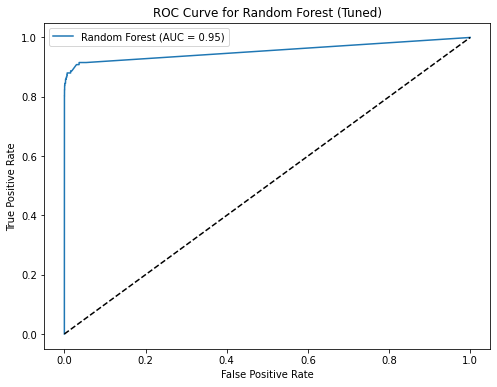

In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest (Tuned)')
plt.legend()
plt.show()


**Streamlit**